In [1]:
from utils.command_handler import ScriptParser, Command
import numpy as np
import cv2
import imutils
from PIL import Image, ImageTk, ImageFont, ImageDraw, ImageChops
from matplotlib import pyplot as plt
import os

In [3]:
os.listdir("animations/base")

['pixel-burn.anim', 'pixel-burn4.anim', 'shining-moon3.anim']

In [18]:
def replace_variables(anim_str, variables):
    for n in range(0, len(variables)):
        var_name = 'var%d'%n
        anim_str = anim_str.replace(var_name, '%2.2f'%variables[n])
    return anim_str


def draw_parametric_animation(anim_str, posx, posy, rota, size, ctime, variables = []):
    canvas = np.zeros((448, 800, 3), np.uint8)
    # print('PARANIM STR:', anim_str)
    
    # scale parameter is from textfile, size is from brush size 
    anim_str = replace_variables(anim_str, variables)
    for obj in anim_str.split('OBJECT')[1:]:
        splitted = obj.splitlines()

        line1 = splitted[0].split(' ')
        typ = line1[1]

        # init parameters
        cx = 0
        cy = 0
        scale = 1

        for line in splitted[1:]:
            line_splt = line.split(' ')
#             line_splt = replace_variables(line_splt, variables)
            if eval(line_splt[0]) <= ctime:
                if eval(line_splt[2]) >= ctime:
                    total_time = eval(line_splt[2])-eval(line_splt[0])
                    completness = (ctime-eval(line_splt[0]))/total_time
                    if line_splt[3] == 'MOVE':
                        change_x = eval(line_splt[7])-eval(line_splt[4])
                        change_y = eval(line_splt[8])-eval(line_splt[5])
                        cx = int(eval(line_splt[4]) + change_x*completness)
                        cy = int(eval(line_splt[5]) + change_y*completness)
                        cx = int(cx*size/100 + 800/2)
                        cy = int(cy*size/100 + 448/2)
                    if line_splt[3] == 'SCALE':
                        change_s = eval(line_splt[6])-eval(line_splt[4])
                        scale = eval(line_splt[4]) + change_s*completness

        if line1[1] == 'rectangle':
            stp = (int(cx-0.5*eval(line1[2])*scale*size/100), int(cy-0.5*eval(line1[3])*scale*size/100))
            enp = (int(cx+0.5*eval(line1[2])*scale*size/100), int(cy+0.5*eval(line1[3])*scale*size/100))
            clr = (eval(line1[4]), eval(line1[4]), eval(line1[4]))
            canvas = cv2.rectangle(canvas, stp, enp, clr, -1)
            
        if line1[1] == 'ellipse':
            axes = (int(eval(line1[2])*scale*size/100), int(eval(line1[3])*scale*size/100))
            clr = (int(line1[5]), int(eval(line1[5])), int(eval(line1[5])))
            canvas = cv2.ellipse(canvas, (cx, cy), axes, 0, 0, 360, clr, -1)

        # now rotate
        canvas_rot = imutils.rotate(canvas, rota)

        # now offset
        pil_img = Image.fromarray(canvas_rot)
        pil_img2 = ImageChops.offset(pil_img, int(posy-800/2), int(posx-448/2))
        canvas_done = np.array(pil_img2)

    return canvas_done

In [19]:
path = "d:/Katalog 1/Projekty/Mikroskop 3.0/laser_microscope/old_soft/mikroskop1/parametric_animations/shining-moon3.anim"
with open(path, "r") as f:
    cnt = f.read()

cnt

'OBJECT ellipse 100 100 0 255\n0.00 -> 0.10 MOVE 0 0 -> 0 0\n0.10 -> 1.00 MOVE 0 0 -> 0 0\n0.10 -> 1.00 SCALE 1.00 -> 1.30\nOBJECT ellipse 100 100 0 0\n0.00 -> 0.10 MOVE -100 0 -> -100 0\n0.10 -> 1.00 MOVE -100 0 -> -25 0\n0.00 -> 0.10 SCALE 0.20 -> 0.20\n0.10 -> 1.00 SCALE 0.20 -> 1.5'

In [31]:
n = 0
inc = 0.1

1.00


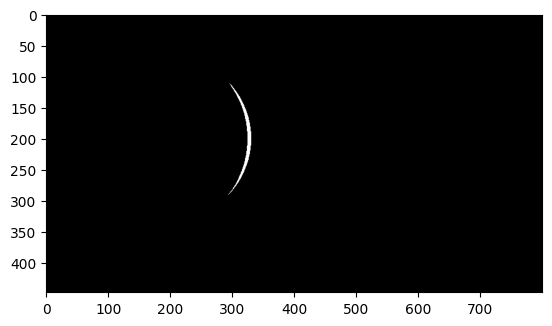

In [42]:
img = draw_parametric_animation(cnt, 200, 200, 0, 100, n)
print(f"{n:.2f}")
n += inc

plt.imshow(img)

In [3]:
def print_command(cmd, nest = 0):
    if type(cmd) == Command:
        print(f"{"   "*nest}{cmd.get_format()}")
    elif type(cmd) == list:
        for c in cmd:
            print_command(c, nest=nest+1)

In [4]:
print_command(scr.commands)

   laser_on()
   set_laser_duty(12)
   operator(var_a, =, 12)
      if(var_a, ==, 12)
      set_laser_duty(5)
   operator(var_x, =, 0)
      loop(4)
      laser_on()
      wait(2)
         if(var_a, >, 12)
         set_laser_duty(1)
      laser_off()
      operator(var_x, +=, 1)
      restart_block()


In [12]:
scr.commands